## Results walkthrough
This notebook contains the code used to produce the pilot results reported as part of a submission to fulfill unit requirements of FIT3144 - Advanced Computer Science Research Project. 

Marcel Masque Salgado, October 2021.


### First, we load the data for bidirectionally connected neurons the Steinmetz dataset
- We load only the data for a particular recording: Probe 1 (0 indexed) from Cori_2016-12-14.
- Bidirectionality was inferred using GLMCC code from Kobayashi et al. 2019. Computational costs mean that it is unfeasible to reproduce this analysis on a notebook. 
1. The file find_connections.py was used to load steinmetz data into the format required by the GLMCC code. 
2. Code for GLMCC, used on the prepared files, can be found in the GLMCC directory. 

#### Load the spike data

In [3]:
times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

(371,)


/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
## Save the data to files
from find_connections import SteinmetzLoader
SteinmetzLoader.save_to_files(good_neurons_probe1, "supercomputer/pawsey/data")

In [1]:
### OBTAIN BIDIRECTIONALLY CONNECTED NEURONS ### 
import numpy as np
probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

### Next, obtain neuron tuples that GLMCC finds to be bidirectionally connected
- Saves to a file: bidirectionally.txt

In [2]:
# get tuples of connected neurons
ai,bi = np.where(abs(probe1_371) != 0)
index_pairs = list(zip(ai,bi))

with open("bidirectionally.txt", 'w') as f:
    bidirectionally = []
    for (r,t) in index_pairs:
        if (t,r) in index_pairs and (t,r) not in bidirectionally:
            bidirectionally.append((r,t))
            f.write(str(t) + " " + str(r) + "\n")

### Compute Phi for these neurons at varying temporal scales
- This was done on the Pawsey supercomputer due to computational constraints
- The file `temporal_emergence.py` provides classes and methods to binarise data, compute Transition Probability Matrices (TPMs) from data, coarse grain TPMs, and compute a TPM's phi using the PyPhi library's nonbinary branch.
- These were then used to compute Phi at varying temporal scales

### Load the results

In [6]:
all_16_macro_micros_connected = np.load("results/all_16coarsegrains_macro_micros_random_fixed1.npy", allow_pickle=True)
all_16_macro_micros_disconnected = np.load("results/all_16coarsegrains_macro_micros_disconnected_fixed1.npy", allow_pickle=True)

### Get the maximums for each coarse graining


In [18]:
def get_max_macros_micros(dataset):
    max_micros_wnan = []
    max_macros_wnan = [[] for i in range(16)]

    for micros,macros,(i,j) in dataset:
        max_micros_wnan.append(np.nanmax(micros))
        max_macro = np.nanmax(macros, axis=(0,1))
        for m in range(len(max_macro)):
            max_macros_wnan[m].append(max_macro[m])

    max_micros = np.array(max_micros_wnan)
    #print([i for i, x in enumerate(~np.isnan(max_micros)) if x])
    max_micros = max_micros[~np.isnan(max_micros)]

    max_macros = [np.array(m_mac) for m_mac in max_macros_wnan]
    max_macros = [m_mac[~np.isnan(m_mac)] for m_mac in max_macros]
    return max_macros, max_micros
max_macros_connected, max_micros_connected = get_max_macros_micros(all_16_macro_micros_connected)
max_macros_disconnected, max_micros_disconnected = get_max_macros_micros(all_16_macro_micros_disconnected)

/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


### Plot the macro Phi values for each coarse graining

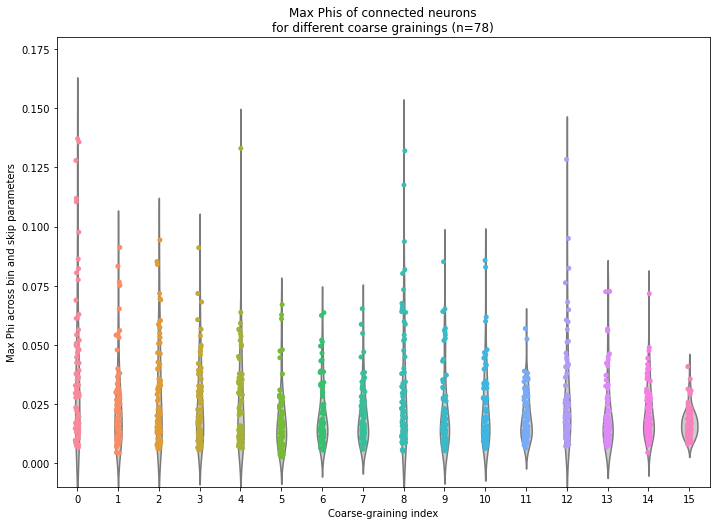

<Figure size 432x288 with 0 Axes>

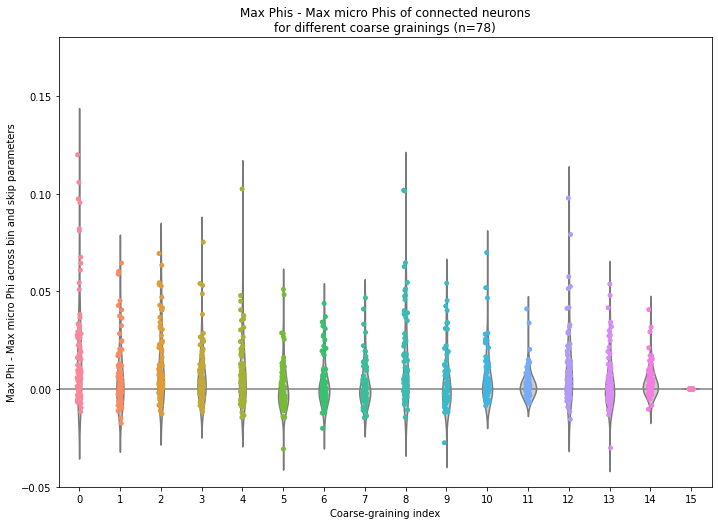

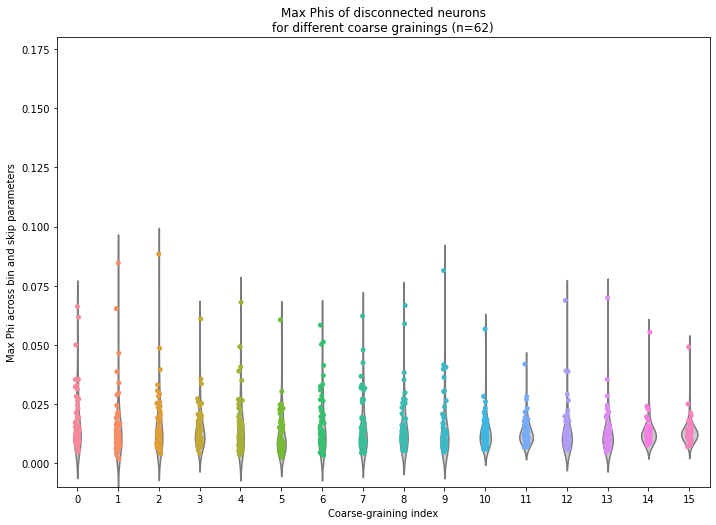

<Figure size 432x288 with 0 Axes>

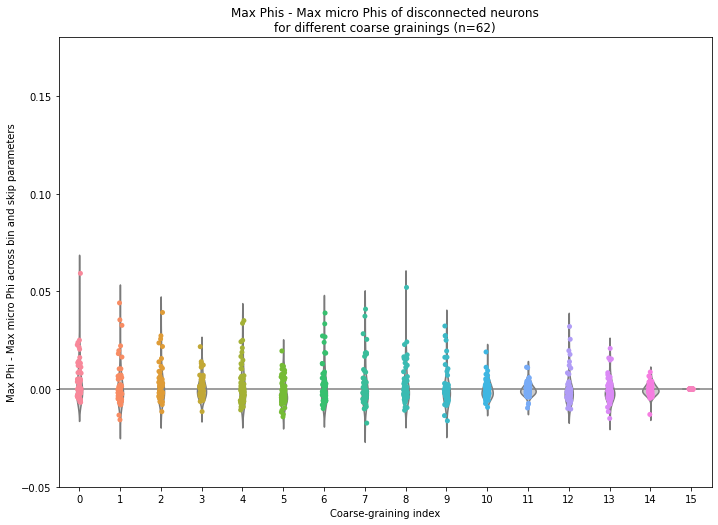

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_max_macros_across_coarsegrainings(max_macros, max_micros, connected):
    df = pd.DataFrame(np.transpose(np.array(max_macros)))
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    ax = sns.violinplot(ax=ax,data=df, orient='v', color=".8", inner=None, width=0.4)
    ax = sns.stripplot(ax=ax,data=df, orient='v',jitter=0.05)
    plt.xlabel("Coarse-graining index")
    plt.ylabel("Max Phi across bin and skip parameters")
    plt.title(f"Max Phis of {connected} neurons\nfor different coarse grainings (n={len(max_macros[0])})")
    plt.ylim([-0.01, 0.18])
    plt.figure()
    fig, ax = plt.subplots(figsize=a4_dims)
    df2 = pd.DataFrame(np.transpose([max_macro - max_micros for max_macro in np.array(max_macros)]))
    ax = sns.violinplot(ax=ax,data=df2, orient='v', color=".8", inner=None, width=0.4)
    ax = sns.stripplot(ax=ax,data=df2, orient='v',jitter=0.05)
    plt.axhline(y=0, color='gray', linestyle='-')
    plt.xlabel("Coarse-graining index")
    plt.ylabel("Max Phi - Max micro Phi across bin and skip parameters")
    plt.title(f"Max Phis - Max micro Phis of {connected} neurons\nfor different coarse grainings (n={len(max_macros[0])})")
    plt.ylim([-0.05, 0.18])

plot_max_macros_across_coarsegrainings(max_macros_connected, max_micros_connected, "connected")
plot_max_macros_across_coarsegrainings(max_macros_disconnected, max_micros_disconnected, "disconnected")


### Get maximum across all macro coarse grainings for every neuron 

In [30]:
#max of all macros
def get_sup_macros(max_macros):
    sup_macros = []
    for i in range(len(max_macros[0])):
        # len - 1 to avoid the last coarse graining, which is the micro
        sup_macros.append(max([max_macros[j][i] for j in range(len(max_macros)-1)]))
    return sup_macros

sup_macros_connected = get_sup_macros(max_macros_connected)
sup_macros_disconnected = get_sup_macros(max_macros_disconnected)


### Get mean across all macro coarse grainings for every neuron

In [26]:
# mean of all macros
def get_mean_macros(max_macros):
    mean_macros = []
    for i in range(len(max_macros[0])):
        mean_macros.append(sum([max_macros[j][i] for j in range(len(max_macros)-1)]) / (len(max_macros)-1))
    return mean_macros
mean_macros_connected = get_mean_macros(max_macros_connected)
mean_macros_disconnected = get_mean_macros(max_macros_disconnected)


### Plot combined plots of the datasets

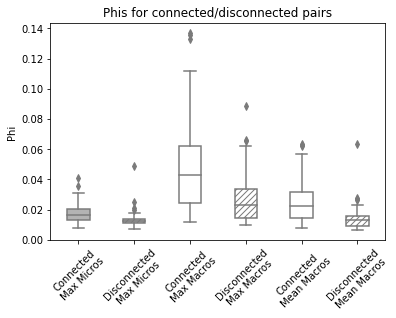

In [33]:
# combined plots
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.boxplot(data=[max_micros_connected, max_micros_disconnected, sup_macros_connected, sup_macros_disconnected, mean_macros_connected, mean_macros_disconnected], orient='v', color=".8", width=0.4)
#ax = sns.stripplot(data=[connected_micros, disconnected_micros, connected_macros, disconnected_macros], orient='v',jitter=0.05)
plt.ylabel("Phi")
plt.xticks(range(6), ["Connected\nMax Micros", "Disconnected\nMax Micros","Connected\nMax Macros", "Disconnected\nMax Macros", "Connected\nMean Macros", "Disconnected\nMean Macros"], rotation=45)
plt.title("Phis for connected/disconnected pairs")

#plt.ylim([-0.03,0.17])
colors = [0.7, 0.7, 1,1,1,1]
for i in range(0,6):
    mybox = ax.artists[i]
    if i in [1,3,5]:
        mybox.set_hatch("////")
    mybox.set_facecolor(str(colors[i]))

## Analysis of individual neuron pair 288, 289
- First we identify the pair with highest phi value and show all its phi values
- Then we show its micro TPM and the macro TPM that maximises Phi


/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: All-NaN slice encountered
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered


0 725
0.13707025
(288, 289)


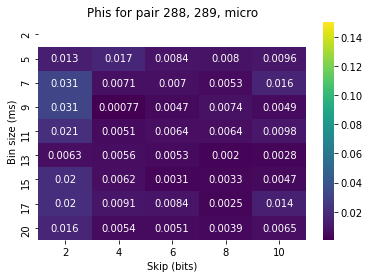

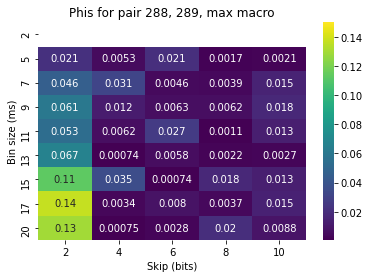

In [45]:

NUM_BITS = 2
skips = list(range(2,11,2))

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
num_binsizes = 9
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)
binsize_strs = [str(int(b*1000)) for b in binsizes]
occurrences = range(100, 1100, 100)
NUM_REPETITIONS = 100

### recompute max phis in a slightly different array format ###
max_micros_wnan = []
max_macros_wnan = [[] for i in range(16)]

for micros,macros,(i,j) in all_16_macro_micros_connected:
    max_micros_wnan.append(np.nanmax(micros))
    max_macro = np.nanmax(macros, axis=(0,1))
    for m in range(len(max_macro)):
        max_macros_wnan[m].append(max_macro[m])
### ###

i,a = np.unravel_index(np.nanargmax(max_macros_wnan), (len(max_macros_wnan), len(max_macros_wnan[0])))
print(i,a)
print(max_macros_wnan[i][a])
index = all_16_macro_micros_connected[a][2]
probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

ax = sns.heatmap(all_16_macro_micros_connected[a][1][:,:,15], annot=True, xticklabels=skips, yticklabels=binsize_strs, cmap="viridis", vmax=0.15)
ax.set_ylabel("Bin size (ms)")
ax.set_xlabel("Skip (bits)")
ax.set_title("Phis for pair 288, 289, micro")

plt.figure()

ax = sns.heatmap(all_16_macro_micros_connected[a][1][:,:,i], annot=True, xticklabels=skips, yticklabels=binsize_strs, cmap="viridis", vmax=0.15)
ax.set_ylabel("Bin size (ms)")
ax.set_xlabel("Skip (bits)")
ax.set_title("Phis for pair 288, 289, max macro")

print(index)

#### Plot the TPM that has maximum Phi

[(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (3, 2), (0, 3), (1, 3), (2, 3), (3, 3)]


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'OFF,OFF'),
  Text(0, 1.5, 'ON,OFF'),
  Text(0, 2.5, 'OFF,ON'),
  Text(0, 3.5, 'ON,ON')])

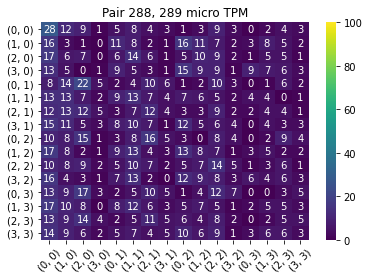

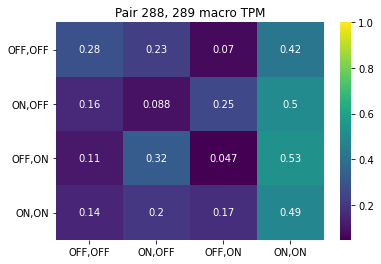

In [49]:
from temporal_emergence import CoarseGrainer, PhiCalculator, Helpers
import pyphi
import numpy as np
import matplotlib.pyplot as plt
import jupyter
import seaborn as sns

states_micro = [(b,a) for (a,b) in Helpers.get_nary_states(2,4)]
print(states_micro)
states_macro = ["OFF,OFF", "ON,OFF", "OFF,ON", "ON,ON"]


TPM_max_phi = np.loadtxt("results/macro_micros_fixed/micro_288_289_occs_200_bin_0.0178625_skip_2.csv")
ax = sns.heatmap((TPM_max_phi*100).astype(int), annot=True, xticklabels=states_micro, yticklabels=states_micro, cmap="viridis", vmax=100)
plt.title("Pair 288, 289 micro TPM")
plt.xticks(rotation=45) 

element_coarse_grainings = [[[0], [1,2,3]], [[0,1,2],[3]], [[0], [1,2], [3]], [[0], [1], [2], [3]]]
states, num_states_l = CoarseGrainer.get_state_maps(element_coarse_grainings)

TPM_max_phi_coarse_grained = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM_max_phi,states[0], num_states_l[0])
plt.figure()
ax = sns.heatmap(TPM_max_phi_coarse_grained, annot=True, xticklabels=states_macro, yticklabels=states_macro, cmap="viridis", vmax=1)
plt.title("Pair 288, 289 macro TPM")

plt.yticks(rotation=0) 
